# ライブラリインストール

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy  
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import seaborn as sns

#import missingno as msno

#from tqdm import tqdm_notebook as tqdm

#import plotly
#plotly.offline.init_notebook_mode(connected=False)

import warnings
warnings.filterwarnings('ignore') # warningが出ないように設定
pd.set_option("display.max_rows", None) # pandasの表示上限をなくす
pd.set_option("display.max_columns", None) # pandasの表示上限をなくす

# 概要
- 事後分布のサンプリング=MCMCで事後分布をサンプリングする
    - マルコフ連鎖を利用する
$$
マルコフ連鎖:新しいθ_tが直前のθ_{t-1}のみから決定する確率過程
$$

- 詳細釣り合い:詳細釣り合いを満たすと、確率分布が定常になる

# stanとは
- HMCを用いたMCMC用のプログラミング言語
## 特徴
- 統計モデルの記述が簡単
- HMCなので高速
- 様々な確率分布を用意している

## 計算の流れ
### 通常のベイズ統計
0. 下調べ：問題の背景を調べる
1. 下調べをもとに,モデルの作成
2. 得られたデータから事後分布の計算（MCMCで計算）

### pystanがやる内容
1. 下調べをもとに,モデルの作成(pystan上にモデリング)
    - データの性質を可視化して、尤度関数、事前分布が決まる　
    - データは正規分布に従いそう
2. 得られたデータから事後分布の計算（MCMCでサンプリング）

## pystanでの流れ
1. モデルの記述/コンパイル
2. データを辞書で定義
3. MCMCでサンプリング
4. 結果の抽出

# 例題(正規分布に従う80個のデータ)
- 観測の目的:与えられたデータからμ,σをのぞご分布を求める

## データの確認

In [2]:
data = np.random.randn(80)

In [22]:
df = pd.DataFrame(data )

In [23]:
df.head()

,0
0,0.449095
1,0.439440
2,-0.106429
3,1.137137
4,-1.591614


## モデルの記述
### ポイント
1. ブロックブロックごとに記述する
    - data/パラメータ/当駅モデル/事前分布のブロックを記述する
2. Stanの文法に従う(C++の文法)

In [10]:
""" 

#　詳細説明
stan_model = """ 
# 得ているデータ
data{
    int N;　#　データの個数
    real Y[N];
}

＃推定するパラメータ
parameters{
    real mu;
    real<lower=0> sigma;
 }
 
 # 統計モデル
 model{ 
     # 正規分布のモデル
     for (i in 1:N){
         Y[i] ~ normal(mu, sigma);
     }
     #事前分布
     mu ~ normal(0, 100);
    
}
""" 

""" 


SyntaxError: invalid syntax (<ipython-input-10-b87a44c41ec3>, line 6)

In [8]:
stan_model = """ 

data{
    int N;
    real Y[N];
}


parameters{
    real mu;
    real<lower=0> sigma;
 }
 
 
 model{ 
     
     for (i in 1:N){
         Y[i] ~ normal(mu, sigma);
     }
     mu ~ normal(0, 100);
    
}
""" 

## モデルのコンパイル

In [9]:
from pystan import StanModel
sm = StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4e5e8e6e17590d16ee6139a07c38a0d2 NOW.


## データを辞書型で渡す

In [24]:
stan_data = {"N":df.shape[0], "Y":df[0]}

## MCMCでサンプリング

In [28]:
fit = sm.sampling(data=stan_data, iter=2000, chains=3, warmup=500)
# iter:反復回数回数
# shains:モンテカルロステッピを行う回数

## 結果の抽出

In [26]:
fit

Inference for Stan model: anon_model_4e5e8e6e17590d16ee6139a07c38a0d2.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.07  1.9e-3   0.11  -0.14-9.5e-4   0.07   0.15   0.29   3492    1.0
sigma    1.0  1.3e-3   0.08   0.86   0.94   0.99   1.05   1.17   3686    1.0
lp__  -39.17    0.02    1.0  -41.9 -39.55 -38.87 -38.46 -38.21   1954    1.0

Samples were drawn using NUTS at Mon Jan  7 16:47:25 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

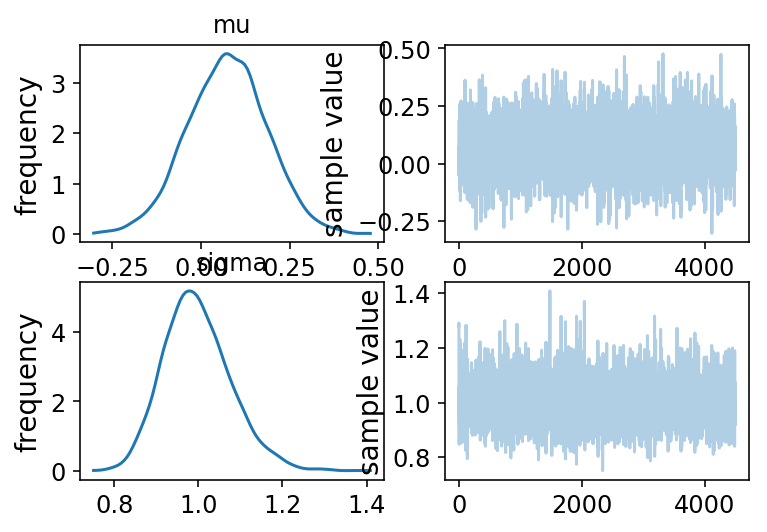

In [27]:
fig = fit.plot()